### Necessary Imports 

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Flatten, Reshape
from tensorflow.keras.layers import Dense, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import os
import math


### Grayscale Image Generator 

In [1]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, .587, 0.114])


### Loading Data 

In [7]:
(X_train, _), (X_test, _) = cifar10.load_data()

img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
channels = X_train.shape[3]

imgs_dir = "saved_images"
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    


170500096/170498071 [==============================] - 11s 0us/step


### Model Parameters

In [0]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]


### Visualizing Grascale And Coloured Images 

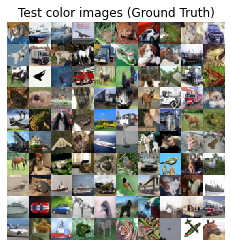

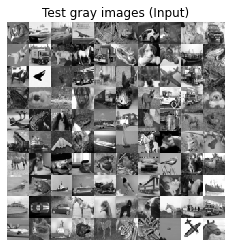

In [12]:
imgs = X_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()


X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)


imgs = X_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

### Datapreprocessing  

In [0]:
# normalize output train and test color images
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# normalize input train and test grayscale images
X_train_gray = X_train_gray.astype('float32') / 255
X_test_gray = X_test_gray.astype('float32') / 255


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)

X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], img_rows,img_cols, 1)
X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], img_rows, img_cols, 1)

### Encoder

In [14]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D(32)-Conv2D(64)

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
    
shape = K.int_shape(x)
    
# Latent Vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs,
                latent,
                name='encoder')

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

### Decoder 

In [18]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense((shape[1]*shape[2]*shape[3]))(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

# reconstruct the input
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731

### AutoencodeR 

In [19]:
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [0]:
save_model_dir = os.path.join(os.getcwd(), "saved_models")
model_name = 'colourizarion_autoencoder.{epoch:03d}.h5'
if not os.path.isdir(save_model_dir):
    os.makedirs(save_model_dir)
filepath = os.path.join(save_model_dir, model_name)


### Training AutoencodeR

In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

autoencoder.compile(loss='mse', optimizer='adam')

callbacks = [lr_reducer, checkpoint]
autoencoder.fit(X_train_gray,
                X_train,
                validation_data=(X_test_gray, X_test),
                epochs=50,
                batch_size=batch_size,
                callbacks=callbacks)


### Tesing Trained Network

In [ ]:
x_decoded = autoencoder.predict(X_test_gray)
display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()